<a href="https://colab.research.google.com/github/PratikStar/google-colab/blob/main/1_2_Create_Audio_Spectrogram_(Windowed_version)_LATEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Some notes
Original owner: sutarpratik2012@gmail.com

But now we need to run this as pratik-sutar@g.ecc.u-tokyo.ac.jp since the [cross account drive sharing is not possible since Dec 2021](https://github.com/googlecolab/colabtools/issues/2418#issuecomment-996238324)

This the LATEST Notebook for Spectrogram creation.

Exported to scripts/audio-to-spectrogram
### References: 

*   Sound of AI: https://www.youtube.com/watch?v=O04v3cgHNeM&list=PL-wATfeyAMNpEyENTc-tVH5tfLGKtSWPp&index=12 
*   https://musicinformationretrieval.com/stft.html. 



## Drive mount

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Pipeline Classes & Code

In [30]:
"""
1- load a file..
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram

PreprocessingPipeline
"""
import os
import pickle
import re
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import inspect
import soundfile as sf
import math

SHOW_LOGS = True
LOG_LEVEL = 1 # {1-6} High Value -> High verbosity

def log(logline, log_level = 1):
    if SHOW_LOGS and log_level <= LOG_LEVEL:
        stack = inspect.stack()
        the_class = stack[1][0].f_locals["self"].__class__.__name__
        the_method = stack[1][0].f_code.co_name
        print("{}.{}: {}".format(the_class, the_method, logline))

class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, offset, load_duration, segment_duration, mono, audio_segments_save_dir):
        self.sample_rate = sample_rate
        self.load_duration = load_duration
        self.segment_duration = segment_duration # This is required to calculate if padding is necessary to a segment
        self.offset = offset
        self.mono = mono
        self.signal = None
        Utils._create_folder_if_it_doesnt_exist(audio_segments_save_dir)

    def load(self, file_path):
        self.signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.load_duration,
                              offset=self.offset,
                              mono=self.mono)[0]
        log("Shape of the loaded signal: " + str(self.signal.shape), 2)
        log("Mean of the loaded signal: " + str(np.mean(self.signal)), 5)
        log("Min of the loaded signal: " + str(np.amin(self.signal)), 5)
        log("Max of the loaded signal: " + str(np.amax(self.signal)), 5)
        log("Raw signal: " + str(self.signal), 6)
        return self.signal
    def save(self, filepath):
        sf.write(filepath, self.signal, self.sample_rate)


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        log("Applying Left Padding: " + str(num_missing_items), 5)
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        log("Applying Right Padding: " + str(num_missing_items), 5)
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        log("Shape of stft: " + str(stft.shape), 2)
        spectrogram = np.abs(stft) # https://librosa.org/doc/main/generated/librosa.stft.html abs gives the magnitude
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram

class FeatureExtractor:
    """ Extracts some features like Clip ID and Passage ID"""

    # Clip ID is same as AmpID
    def extract_clipid_from_name(self, filename):
        clip_id = int(filename.split('-')[0])
        log("Clip ID: " + str(clip_id), 5)
        return clip_id

    # Passage ID is equivalent to what used to be 'subclip' ID
    def extract_passageid_from_name(self, filename):
        passage_id = int(filename.split('-')[1].split(' ')[0])
        log("Passage ID: " + str(passage_id), 5)
        return passage_id

class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):

        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        log("Shape of normalized array: " + str(norm_array.shape), 2)
        log("Max of norm_array: " + str((array.max())), 2)
        log("Min of norm_array: " + str((array.min())), 2)
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        Utils._create_folder_if_it_doesnt_exist(self.feature_save_dir)
        self.min_max_values_save_dir = min_max_values_save_dir
        Utils._create_folder_if_it_doesnt_exist(self.min_max_values_save_dir)

    def save_feature(self, feature, file_name):
        save_path = self._generate_save_path(file_name)
        np.save(save_path, feature)
        return save_path

    def save_min_max_values(self, file_name, min_value, max_value):
        pkl_file = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        data = {}
        if os.path.exists(pkl_file) and os.path.getsize(pkl_file) > 0:
            with open(pkl_file, 'rb') as f:
                data = pickle.load(f)
        data[file_name] = {
            "min": min_value,
            "max": max_value
        }
        with open(pkl_file, 'wb') as f:    
            pickle.dump(data, f)


    def _generate_save_path(self, file_name):
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path

class Visualizer:
    def __init__(self, file_dir, frame_size, hop_length, offset):
        self.file_dir = file_dir
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.offset = offset
    
    def visualize(self, spectrogram, file_name, spectrogram_img_save_flg=False):
        plt.ioff()
        fig, ax = plt.subplots(dpi=120)
        try:
            img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax)
        except IndexError as e:
            log("Null spectrogram for file: " + file_name, 1)
            return
        ax.set_title("Frame Size: {}, Hop length: {}, Offset: {}\n{}".format(self.frame_size, self.hop_length, self.offset, file_name.split(".")[0]))
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
        Utils._create_folder_if_it_doesnt_exist(self.file_dir)
        if spectrogram_img_save_flg:
            fig.savefig(os.path.join(self.file_dir, re.sub('\.[a-z]*$', '.png', file_name)))        
        plt.close(fig)

class Utils:
    def __init__(self):
        pass
    @staticmethod
    def _create_folder_if_it_doesnt_exist(folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

class AudioReconstructor:
    """Processes stft inverse and saves the audio file"""
    def __init__(self, file_dir, hop_length, frame_size):
        self.file_dir = file_dir
        self.hop_length = hop_length
        self.frame_size = frame_size
        Utils._create_folder_if_it_doesnt_exist(self.file_dir)

    def reconstruct(self, features, file_name):
        # Invert using Griffin-Lim
        log("Shape of features: " + str(features.shape), 1)
        features_inv = librosa.griffinlim(features,
                                          hop_length=self.hop_length,
                                          win_length=self.frame_size)
        log("Shape of Inverse features: " + str(features_inv.shape), 1)
        Utils._create_folder_if_it_doesnt_exist(self.file_dir)
        sf.write(os.path.join(self.file_dir, file_name ), y_inv, 22050)
        # save audio
    def reconstruct_from_path(self, file_path):
        # Invert using Griffin-Lim
        features = np.load(file_path)
        self.reconstruct(features, os.path.basename(file_path))
    
class PreprocessingPipeline:
    """PreprocessingPipeline processes a single audio file, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.spectrogram_extractor = None
        self.feature_extractor = None
        self.normaliser = None
        self.saver = None
        self.visualizer = None
        self.reconstructor = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.segment_duration)

    # Processes Single file
    def process_file(self, audio_files_dir, audio_passage_file_name, segment_id, spectrogram_save_flg=False, spectrogram_img_save_flg=False, visualize_flg=True, external_features_flg=False, save_segments_flg=False):
        name_split = audio_passage_file_name.split(" ")
        file_name = name_split[0] + "-{:02d} ".format(segment_id) + " ".join(name_split[1:])
        log("Processing Segment: " + file_name)

        file_path = os.path.join(audio_files_dir, audio_passage_file_name)
        signal = self.loader.load(file_path)
        if external_features_flg:
            external_features = [ self.feature_extractor.extract_clipid_from_name(audio_passage_file_name),
                                  self.feature_extractor.extract_passageid_from_name(audio_passage_file_name),
                                  segment_id                         
                                ]
            signal = np.concatenate((external_features, signal))
            log("Shape of the signal after concatenating external features: " + str(signal.shape))

        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.spectrogram_extractor.extract(signal)

        norm_feature = self.normaliser.normalise(feature)


        if visualize_flg or spectrogram_img_save_flg:
            self.visualizer.visualize(norm_feature, file_name, spectrogram_img_save_flg)

        if spectrogram_save_flg:
            save_path = self.saver.save_feature(norm_feature, file_name)
            self.saver.save_min_max_values(file_name, feature.min(), feature.max())
        
        if save_segments_flg:
            self.loader.save(file_name)
        
    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            log("Padding necessary", 1)
            log("Actual Signal length: " + str(len(signal)), 5)
            log("Expected samples in signal: " + str(self._num_expected_samples), 5)
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal



## Driver Code

In [31]:
## TOBE <CLIP_ID>-<PASSAGE_ID>-<SEGMENT_ID> <AMP_NAME>.wav.npy
## 00000-06-00 DI.wav.png is not present

### For Audio Loading
SAMPLE_RATE = 22050
MONO = True

### For STFT
FRAME_SIZE = 512
HOP_LENGTH = FRAME_SIZE // 2 
SEGMENT_DURATION = 0.74  # in seconds

# Dimensions: (FRAME_SIZE / 2) x ceil(SAMPLE_RATE * DURATION / HOP_LENGTH)

### For Processing
MAX_NUMBER_OF_SEGMENTS = math.inf
SAVE_SEGMENTS_FLG=True
SPECTROGRAM_SAVE_FLG=True
SPECTROGRAM_IMG_SAVE_FLG=True
VISUALIZE_FLG=False
EXTERNAL_FEATURES_FLG=False


### INPUT. Read-only
AUDIO_FILES_DIR = "/content/drive/MyDrive/Music/VAE/audio/" # passages present here
AUDIO_REGEX = "^.*\.wav$"


### OUTPUT
SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/spectrogram-2022/"
SPECTROGRAMS_IMG_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/spectrogram-img-2022/"
RECONSTRUCTED_AUDIO_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/audio-reconstructed-2022/"
MIN_MAX_VALUES_SAVE_DIR = SPECTROGRAMS_SAVE_DIR
AUDIO_SEGMENTS_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/audio-segments/"

# instantiate all objects
# loader = None # Loader is initialized later
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
feature_extractor = FeatureExtractor()
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)
# visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH, OFFSET) # Initialized later since we need to calculate Offset
reconstructor = AudioReconstructor(RECONSTRUCTED_AUDIO_SAVE_DIR, HOP_LENGTH, FRAME_SIZE)

preprocessing_pipeline = PreprocessingPipeline()
# preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.spectrogram_extractor = log_spectrogram_extractor
preprocessing_pipeline.feature_extractor = feature_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver
preprocessing_pipeline.reconstructor = reconstructor

processed_segments = 0
break_outer = False
# for root, _, files in os.walk(AUDIO_FILES_DIR):
for filename in os.listdir(AUDIO_FILES_DIR):
    if re.match(AUDIO_REGEX, filename):

        # Load file just to get duration
        y, sr = librosa.load(os.path.join(AUDIO_FILES_DIR, filename), sr=SAMPLE_RATE, mono=MONO)
        duration = librosa.get_duration(y=y, sr=sr)
        segment_id = 0
        while True:
            if (segment_id) * SEGMENT_DURATION >= duration:
                break # expected: break inner
            if processed_segments == MAX_NUMBER_OF_SEGMENTS:
                break_outer = True
                break # expected: break outer
            processed_segments += 1                
            offset = segment_id * SEGMENT_DURATION
            loader = Loader(SAMPLE_RATE, offset, min(SEGMENT_DURATION, duration - offset), SEGMENT_DURATION, MONO, AUDIO_SEGMENTS_SAVE_DIR)
            preprocessing_pipeline.loader = loader
            visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH, offset)
            preprocessing_pipeline.visualizer = visualizer

            preprocessing_pipeline.process_file(AUDIO_FILES_DIR, filename, segment_id,  spectrogram_save_flg=SPECTROGRAM_SAVE_FLG, spectrogram_img_save_flg=SPECTROGRAM_IMG_SAVE_FLG, visualize_flg=VISUALIZE_FLG, external_features_flg=EXTERNAL_FEATURES_FLG, save_segments_flg=SAVE_SEGMENTS_FLG)
            segment_id += 1
        if break_outer:
            break



PreprocessingPipeline.process_file: Processing Segment: 00001-11-00 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-01 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-02 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-03 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-04 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-05 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-06 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-07 01A US Double Nrm.wav
PreprocessingPipeline.process_file: Processing Segment: 00001-11-08 01A US Double Nrm.wav
PreprocessingPipeline._is_padding_necessary: Padding necessary
PreprocessingPipeline.process_file: Processing Segment: 00001-04-00 01A US Double Nrm.wav
PreprocessingPipeline.process_file: P

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide


Streaming output truncated to the last 5000 lines.
PreprocessingPipeline._is_padding_necessary: Padding necessary
PreprocessingPipeline.process_file: Processing Segment: 00004-01-00 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-01 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-02 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-03 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-04 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-05 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-06 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-07 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-08 01D Cali Rectifire.wav
PreprocessingPipeline.process_file: Processing Segment: 00004-01-09

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Streaming output truncated to the last 5000 lines.
PreprocessingPipeline.process_file: Processing Segment: 00049-06-09 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-06-10 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-06-11 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-06-12 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-06-13 13A Cowboys from DFW.wav
PreprocessingPipeline._is_padding_necessary: Padding necessary
PreprocessingPipeline.process_file: Processing Segment: 00049-01-00 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-01-01 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-01-02 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Segment: 00049-01-03 13A Cowboys from DFW.wav
PreprocessingPipeline.process_file: Processing Se

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-00 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-01 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-02 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-03 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-04 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-05 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PreprocessingPipeline.process_file: Processing Segment: cut00080-07-06 20D THIS IS THE END.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


PreprocessingPipeline._is_padding_necessary: Padding necessary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


## Test clips (Not tested in 2022)

In [ ]:
## TOBE <AMP_ID>-<CLIP_ID>-<SEGMENT_ID> <AMP_NAME>.wav.npy
## 00000-06-00 DI.wav.png is not present
# rock acoustic: https://www.youtube.com/watch?v=hf7e0eRu5Jg
# rock: https://www.youtube.com/watch?v=w6MiJUTZ6n8

FRAME_SIZE = 512
HOP_LENGTH = FRAME_SIZE // 2 # smaller better?
OFFSET = 0
WINDOW_DURATION = 0.74  # in seconds
SAMPLE_RATE = 22050
MONO = True

# Dimensions: (FRAME_SIZE / 2) x ceil(SAMPLE_RATE * DURATION / HOP_LENGTH)

## SOURCE
AUDIO_FILES_DIR = "/content/drive/MyDrive/Music/VAE/audio-test/rock-samples"
AUDIO_REGEX = ".*"

## OUTPUT
SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/ICASSP/spectrogram-testing/"
SPECTROGRAMS_IMG_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/ICASSP/spectrogram-img-testing/"
RECONSTRUCTED_AUDIO_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/ICASSP/audio-reconstructed-test/"
MIN_MAX_VALUES_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/ICASSP"

NUMBER_OF_CLIPS = 10000000

# instantiate all objects
# loader = Loader(SAMPLE_RATE, OFFSET, WINDOW_DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
feature_extractor = FeatureExtractor()
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)
visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH, OFFSET)
reconstructor = AudioReconstructor(RECONSTRUCTED_AUDIO_SAVE_DIR, HOP_LENGTH, FRAME_SIZE)

preprocessing_pipeline = PreprocessingPipeline()
# preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.feature_extractor = feature_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver
preprocessing_pipeline.reconstructor = reconstructor

number_of_clips = NUMBER_OF_CLIPS
for root, _, files in os.walk(AUDIO_FILES_DIR):
    for file in files:

        if re.match(AUDIO_REGEX, file) and number_of_clips > 0:
            print(file)
            number_of_clips -= 1
            y, sr = librosa.load(os.path.join(AUDIO_FILES_DIR, file), sr=SAMPLE_RATE, mono=MONO)
                
            offset = 0
            loader = Loader(SAMPLE_RATE, offset, WINDOW_DURATION, WINDOW_DURATION, MONO)
            preprocessing_pipeline.loader = loader
            visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, HOP_LENGTH, offset)
            preprocessing_pipeline.visualizer = visualizer

            preprocessing_pipeline.process_file(AUDIO_FILES_DIR, file, 0, save_flg=True, visualize_flg=True, external_features_flg=False)



livin-on-a-prayer.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-livin-on-a-prayer.wav
smells-like-teen-spirit.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-smells-like-teen-spirit.wav
sweet-child-o-mine.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-sweet-child-o-mine.wav
black-hole-sun.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-black-hole-sun.wav
sultans-of-swing.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-sultans-of-swing.wav
november-rain.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-november-rain.wav
here-i-go-again.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-here-i-go-again.wav
basket-case.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-basket-case.wav
eye-of-the-tiger.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-eye-of-the-tiger.wav
heart-shaped-box.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


	rock-heart-shaped-box.wav


## Miscellaneous 

### To find optimal length (Independently Executable)

In [ ]:
### For Audio Loading
SAMPLE_RATE = 22050
MONO = True

### For STFT
FRAME_SIZE = 512
SEGMENT_DURATION = 0.74 # in seconds

### For Processing
SPECTROGRAM_IMG_SAVE_FLG=True
VISUALIZE_FLG=True


### INPUT. Read-only
AUDIO_FILES_DIR = "/content/drive/MyDrive/Music/VAE/audio/"
AUDIO_FILE_NAME = "00000-05 DI.wav"

### OUTPUT
SPECTROGRAMS_SAVE_DIR = "/content/"
SPECTROGRAMS_IMG_SAVE_DIR = "/content/drive/MyDrive/Music/VAE/spectrogram-img-hop_length-test/"
MIN_MAX_VALUES_SAVE_DIR = "/content/"


# instantiate all objects
padder = Padder()
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.padder = padder
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

for i in range(2, 512, 20):
    print(i)
    OFFSET = 0.7

    loader = Loader(SAMPLE_RATE, OFFSET, SEGMENT_DURATION, SEGMENT_DURATION, MONO)
    preprocessing_pipeline.loader = loader

    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, i)
    preprocessing_pipeline.spectrogram_extractor = log_spectrogram_extractor

    visualizer = Visualizer(SPECTROGRAMS_IMG_SAVE_DIR, FRAME_SIZE, i, OFFSET)
    preprocessing_pipeline.visualizer = visualizer

    preprocessing_pipeline.process_file(AUDIO_FILES_DIR, AUDIO_FILE_NAME, i, spectrogram_img_save_flg=SPECTROGRAM_IMG_SAVE_FLG, visualize_flg=VISUALIZE_FLG)
    # break

2
PreprocessingPipeline: Processing Segment: 00000-05-02 DI.wav
22
PreprocessingPipeline: Processing Segment: 00000-05-22 DI.wav
42
PreprocessingPipeline: Processing Segment: 00000-05-42 DI.wav
62
PreprocessingPipeline: Processing Segment: 00000-05-62 DI.wav
82
PreprocessingPipeline: Processing Segment: 00000-05-82 DI.wav
102
PreprocessingPipeline: Processing Segment: 00000-05-102 DI.wav
122
PreprocessingPipeline: Processing Segment: 00000-05-122 DI.wav
142
PreprocessingPipeline: Processing Segment: 00000-05-142 DI.wav
162
PreprocessingPipeline: Processing Segment: 00000-05-162 DI.wav
182
PreprocessingPipeline: Processing Segment: 00000-05-182 DI.wav
202
PreprocessingPipeline: Processing Segment: 00000-05-202 DI.wav
222
PreprocessingPipeline: Processing Segment: 00000-05-222 DI.wav
242
PreprocessingPipeline: Processing Segment: 00000-05-242 DI.wav
262
PreprocessingPipeline: Processing Segment: 00000-05-262 DI.wav
282
PreprocessingPipeline: Processing Segment: 00000-05-282 DI.wav
302
Pr

### Tested: Reconstructing the Audio (Independent)

Min: -57.176361083984375
Max: 22.823640823364258
(257, 64)


Text(0.5, 1.0, 'inverted_magnitude_spectrogram')

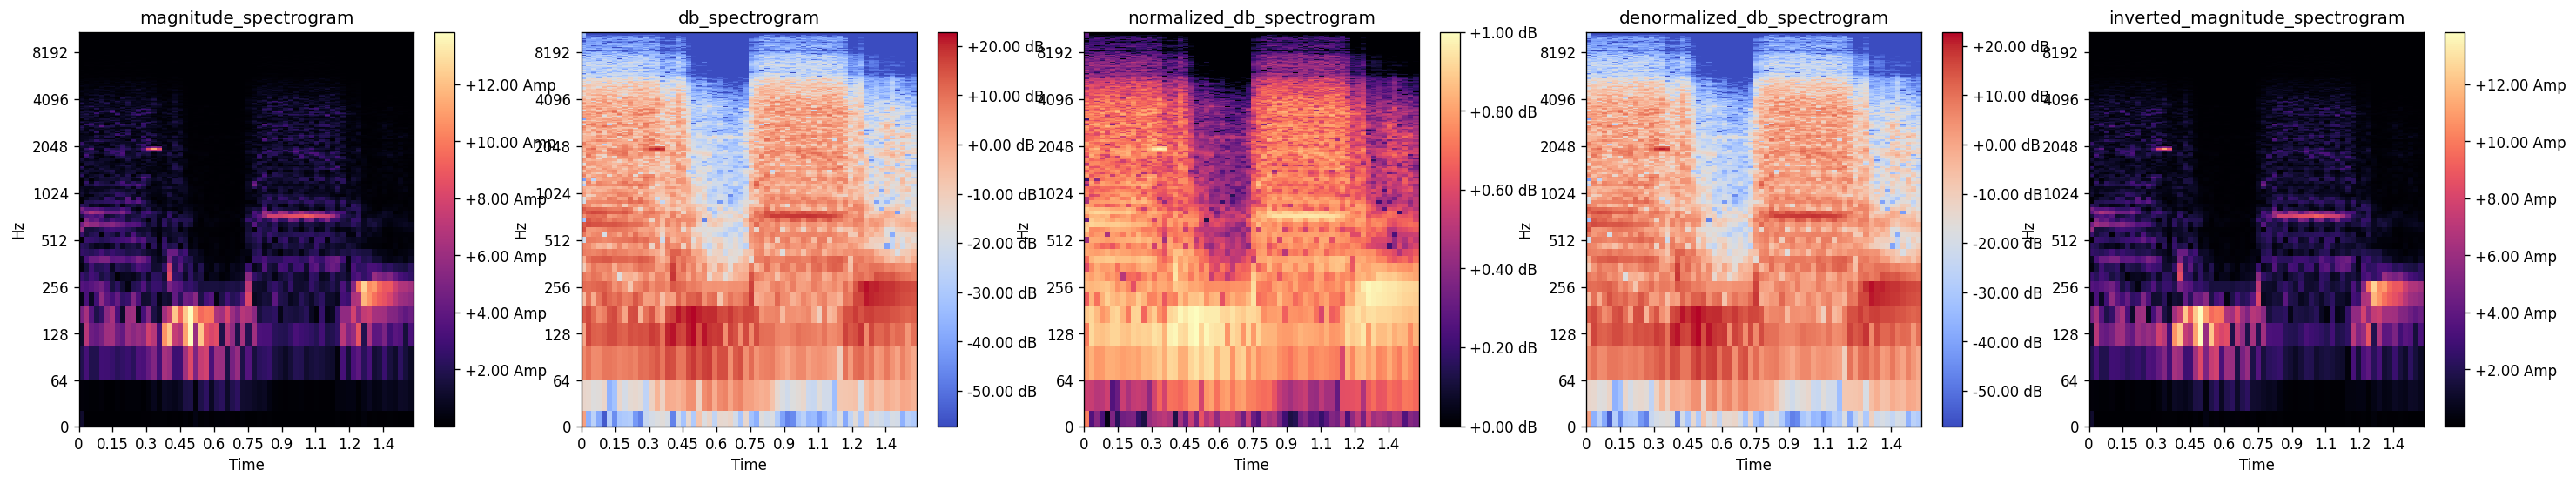

In [10]:
import soundfile as sf
import librosa
import librosa.display
import numpy as np

############### AUDIO --> load --> stft --> np.abs --> amplitude_to_db --> normalize --> SPECTROGRAM
y, sr = librosa.load('/content/drive/MyDrive/Music/VAE/audio-segments/00003-05-07 01C Brit Plexi Jump.wav',
                     sr=22050,
                    #  duration=0.74,
                    #  offset=0.5,
                     mono=True)
stft = librosa.stft(y,
                    n_fft=512, # framesize
                    hop_length=256 # frame_size/2
                    )
magnitude_spectrogram = np.abs(stft)
phase_spectrogram = np.angle(stft) # not used

db_spectrogram = librosa.amplitude_to_db(magnitude_spectrogram)

min_value,max_value = 0, 1
og_db_min, og_db_max = db_spectrogram.min(), db_spectrogram.max()
normalized_db_spectrogram = (db_spectrogram - db_spectrogram.min()) / (db_spectrogram.max() - db_spectrogram.min())
print("Min: {}".format(og_db_min))
print("Max: {}".format(og_db_max))
normalized_db_spectrogram = normalized_db_spectrogram * (max_value - min_value) + min_value
print(normalized_db_spectrogram.shape)
###############


############### SPECTROGRAM --> denormalize --> db_to_amplitude --> griffinlim --> AUDIO
denormalized_db_spectrogram = (normalized_db_spectrogram - min) / (max - min)
denormalized_db_spectrogram = denormalized_db_spectrogram * (og_db_max - og_db_min) + og_db_min

inverted_magnitude_spectrogram = librosa.db_to_amplitude(denormalized_db_spectrogram)

y_inv = librosa.griffinlim(inverted_magnitude_spectrogram,
                           hop_length=256
                           ) # "Approximate magnitude spectrogram inversion"
sf.write('/content/drive/MyDrive/Music/VAE/audio-reconstructed-2022/griffinlim 00003-05-07 01C Brit Plexi Jump.wav', y_inv, sr)

# Invert without estimating phase
y_istft = librosa.istft(inverted_magnitude_spectrogram,
                        hop_length=256)
sf.write('/content/drive/MyDrive/Music/VAE/audio-reconstructed-2022/istft 00003-05-07 01C Brit Plexi Jump.wav', y_istft, sr)
###############


############### Plotting
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
fig, ax = plt.subplots(ncols=5, dpi=120, figsize=(30, 5))

img = librosa.display.specshow(magnitude_spectrogram, y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=ax[0], format="%+2.2f Amp")
ax[0].set_title("magnitude_spectrogram")

img = librosa.display.specshow(db_spectrogram, y_axis='log', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=ax[1], format="%+2.2f dB")
ax[1].set_title("db_spectrogram")

img = librosa.display.specshow(normalized_db_spectrogram, y_axis='log', x_axis='time', ax=ax[2])
fig.colorbar(img, ax=ax[2], format="%+2.2f dB")
ax[2].set_title("normalized_db_spectrogram")

img = librosa.display.specshow(denormalized_db_spectrogram, y_axis='log', x_axis='time', ax=ax[3])
fig.colorbar(img, ax=ax[3], format="%+2.2f dB")
ax[3].set_title("denormalized_db_spectrogram")

img = librosa.display.specshow(inverted_magnitude_spectrogram, y_axis='log', x_axis='time', ax=ax[4])
fig.colorbar(img, ax=ax[4], format="%+2.2f Amp")
ax[4].set_title("inverted_magnitude_spectrogram")

# img = librosa.display.specshow(y_inv, y_axis='log', x_axis='time', ax=ax[1])

# librosa.display.waveshow(y, sr=sr, color='b', ax=ax[0])
# ax[0].set(title='Original', xlabel=None)
# ax[0].label_outer()
# librosa.display.waveshow(y_inv, sr=sr, color='g', ax=ax[1])
# ax[1].set(title='Griffin-Lim reconstruction', xlabel=None)
# ax[1].label_outer()
# librosa.display.waveshow(y_istft, sr=sr, color='r', ax=ax[2])
# ax[2].set_title('Magnitude-only istft reconstruction')